In [227]:
def go(plot=False):
    import torch
    import numpy as np
    from matplotlib import pyplot as plt

    # TODO adjust these hyperparameters to get a good classifier
    #threshold = 100
    num_iter = 20
    accuracy = 0
    """
    Read data from the specified training, validation and test data files.
    """
    def read_data(trainFile, valFile, testFile):
        features = []
        labels = []

        # read training, test, and validation data
        for file in [trainFile, valFile, testFile]:
            # read data
            data = np.loadtxt(file)

            # transform into our feature space with "fe()"
            features.append(fe(torch.tensor(data[:,:-1])))

            labels.append(torch.tensor(data[:,-1]))

        return features[0], labels[0], features[1], \
            labels[1], features[2], labels[2]

    """
    Feature that counts the number of pixels above a specified threshold
    in each row and column.
    """
    def fe(X):
        # get a "binary image" indicator of pixels above and below the threshold
        X_binary = torch.where(X > threshold,
            torch.ones_like(X),torch.zeros_like(X)).reshape(-1,28,28)

        # calculate row and column features
        X_row = X_binary.sum(dim=1)
        X_col = X_binary.sum(dim=2)

        # include a row of ones at the end for bias
        return torch.cat([X_row, X_col, torch.ones(X_row.shape[0], 
            1, dtype=torch.float64)], dim=1)

    """
    Convert "y" into its one-hot-encoding equivalent.
    """
    def one_hot(y):
        y_one_hot = torch.zeros([y.shape[0], 10], dtype=torch.float64)
        return y_one_hot.scatter(1, y.reshape(-1, 1).to(torch.long), 1)

    """
    Get the scores for each class for each training point.
    """
    def sigmoid(z):

        return 1 / (1 + torch.exp(-z))

    def get_scores(X, w):

        return sigmoid(torch.mm(X,w.T))
    
    def get_batch(X,y,size = 100):
        for i in range(0, X.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
            yield X[i:i + batchSize], y[i:i + batchSize]
        


    """
    Train the model using regularized logistic regression.
    """
    def train(X,y):
        # convert index labels of y into a one-hot encoding
        one_hot_y = one_hot(y)

        # loss list over iterations for plotting
        losses = []

        # initialize model weights
        w = torch.rand((10, X.shape[1]), dtype=torch.float64, requires_grad=True)

        i = 0
        while i < num_iter:

            criterion = torch.nn.CrossEntropyLoss()
            z = torch.mm(X,w.T)
            #yz = torch.mm(y.reshape().T,z)
            loss = criterion(z, y.to(torch.long))+ reg_factor * torch.sum(w ** 2)
            #loss = torch.sum(torch.log(1+torch.exp(-yz))).mean()+ reg_factor * torch.sum(w ** 2)

            # <- TODO delete

            # calculate loss gradient 
            loss.backward()

            # save for plotting
            losses.append(loss.item())

            # TODO try using different optimization methods here
            
            #batch = next_training_batch(data, 256)


            
            with torch.no_grad():
                w.sub_(learning_rate * w.grad)
            w.grad.data.zero_()

            i += 1

        return w, losses

    """
    Get list of predicted labels for feature set "X" using model 
    parameterized by w.
    """
    def predict(X, w):
        # get scores for each class for each input
        scores = get_scores(X, w)
        # find the index of the maximum score for each input,
        # which happens to exactly correspond to the label!
        return torch.argmax(scores, dim=1)

    """
    Evaluate the model parameterized by "w", using unseen data features "X" and
    corresponding labels "y".
    """
    def evaluate(X, y, w):
        # use model to get predictions
        predictions = predict(X, w)

        # total number of items in dataset
        total = y.shape[0]

        # number of correctly labeled items in dataset
        correct = torch.sum(predictions == y.long())

        # return fraction of correctly labeled items in dataset
        return float(correct) / float(total)

    if __name__ == "__main__":
        # load data from file
        train_vec, train_lab, val_vec, val_lab, test_vec, test_lab \
            = read_data('hw0train.txt','hw0validate.txt', 'hw0test.txt')

        # find w through gradient descent
        w, losses = train(train_vec,train_lab)

        # evaluate model on validation data
        accuracy = evaluate(val_vec, val_lab, w)

        #print("Validation accuracy: {}".format(accuracy))

        # plot losses
        if plot:
            plt.plot(losses)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.title("Loss plot")
            plt.show()
        return accuracy

Validation accuracy: 0.241


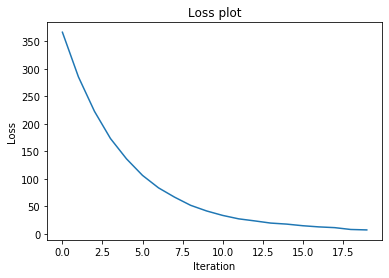

In [218]:
go()

In [215]:
learning_rate = 0.032
reg_factor = 1.8

In [ ]:
max_acc = 0
best_learn = 0
best_reg = 0
for i in np.arange(0.01,0.1,0.002):
    for j in np.arange(1,2,0.1):
        for k in np.arange(30,200,10):
            threshold = k
            learning_rate = i
            reg_factor = j
            temp = go()
            if temp>max_acc:
                max_acc = temp
                best_learn = i
                best_reg = j
                best_threshold = k
print(max_acc,best_learn,best_reg,best_threshold)